In [ ]:
import pandas as pd
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Load the datasets
train_df = pd.read_csv('/content/twitter_training.csv')
val_df = pd.read_csv('/content/twitter_validation.csv')

In [ ]:
# Rename columns
train_df.columns = ['id', 'product', 'sentiment', 'text']
val_df.columns = ['id', 'product', 'sentiment', 'text']

In [ ]:
train_df

,id,product,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Lowercase text
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    else:
        text = ''
    return text

In [ ]:
# Apply the clean_text function to the 'text' column
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

In [ ]:
# Ensure there are no NaN values in 'sentiment' column
train_df = train_df.dropna(subset=['sentiment'])
val_df = val_df.dropna(subset=['sentiment'])

In [ ]:
# Map sentiment labels to integers
label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
train_df['sentiment'] = train_df['sentiment'].map(label_map)
val_df['sentiment'] = val_df['sentiment'].map(label_map)

In [ ]:
# Remove any rows with NaN values in 'cleaned_text' or 'sentiment'
train_df = train_df.dropna(subset=['cleaned_text', 'sentiment'])
val_df = val_df.dropna(subset=['cleaned_text', 'sentiment'])

In [ ]:
# Remove any rows with invalid label values
train_df = train_df[train_df['sentiment'].isin([0, 1, 2])]
val_df = val_df[val_df['sentiment'].isin([0, 1, 2])]

In [ ]:

# Check the dataset to ensure it's correct
print("Training data head:\n", train_df.head())
print("Validation data head:\n", val_df.head())

Training data head:
      id      product  sentiment  \
0  2401  Borderlands        0.0   
1  2401  Borderlands        0.0   
2  2401  Borderlands        0.0   
3  2401  Borderlands        0.0   
4  2401  Borderlands        0.0   

                                                text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                        cleaned_text  
0  i am coming to the borders and i will kill you...  
1  im getting on borderlands and i will kill you all  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands and i will murder yo...  
4  im getting into borderlands and i can murder y...  
Validation data head:
      id    product  sentiment  \
0   352     Amazon        2.0   
1  8312  Mic

In [ ]:
# Tokenization and padding
max_words = 10000  # Maximum number of words to keep, based on word frequency
max_len = 100  # Maximum length of sequences


In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])

In [ ]:
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_text'])

In [ ]:
# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

In [ ]:
# Prepare labels
train_labels = train_df['sentiment'].values
val_labels = val_df['sentiment'].values

In [ ]:
# Check for any invalid label values
print("Unique train labels:", set(train_labels))
print("Unique validation labels:", set(val_labels))


Unique train labels: {0.0, 1.0, 2.0}
Unique validation labels: {0.0, 1.0, 2.0}


In [ ]:
# Ensure labels are of integer type
train_labels = train_labels.astype(int)
val_labels = val_labels.astype(int)

In [ ]:
# Check the shape of the padded sequences and labels
print("Train padded shape:", train_padded.shape)
print("Validation padded shape:", val_padded.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train padded shape: (61691, 100)
Validation padded shape: (828, 100)
Train labels shape: (61691,)
Validation labels shape: (828,)


In [ ]:
# Define the RNN model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes: Positive, Negative, Neutral
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))


Epoch 1/10
1928/1928 [==============================] - 714s 368ms/step - loss: 1.0962 - accuracy: 0.3598 - val_loss: 1.1040 - val_accuracy: 0.3213
Epoch 2/10
1928/1928 [==============================] - 709s 368ms/step - loss: 1.0956 - accuracy: 0.3637 - val_loss: 1.1036 - val_accuracy: 0.3213
Epoch 3/10
1928/1928 [==============================] - 710s 368ms/step - loss: 1.0954 - accuracy: 0.3635 - val_loss: 1.1044 - val_accuracy: 0.3213
Epoch 4/10
1928/1928 [==============================] - 706s 366ms/step - loss: 1.0954 - accuracy: 0.3645 - val_loss: 1.1045 - val_accuracy: 0.3213
Epoch 5/10
1928/1928 [==============================] - 705s 366ms/step - loss: 1.0854 - accuracy: 0.3858 - val_loss: 1.0488 - val_accuracy: 0.4505
Epoch 6/10
1928/1928 [==============================] - 706s 366ms/step - loss: 0.9160 - accuracy: 0.5907 - val_loss: 0.7033 - val_accuracy: 0.7319
Epoch 7/10
1928/1928 [==============================] - 703s 365ms/step - loss: 0.7286 - accuracy: 0.7057 - val_

In [ ]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(val_padded, val_labels)
print(f'Validation Accuracy: {accuracy:.4f}')

26/26 [==============================] - 3s 106ms/step - loss: 0.4233 - accuracy: 0.8502
Validation Accuracy: 0.8502


In [ ]:
# Generate word cloud
all_text = ' '.join(train_df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

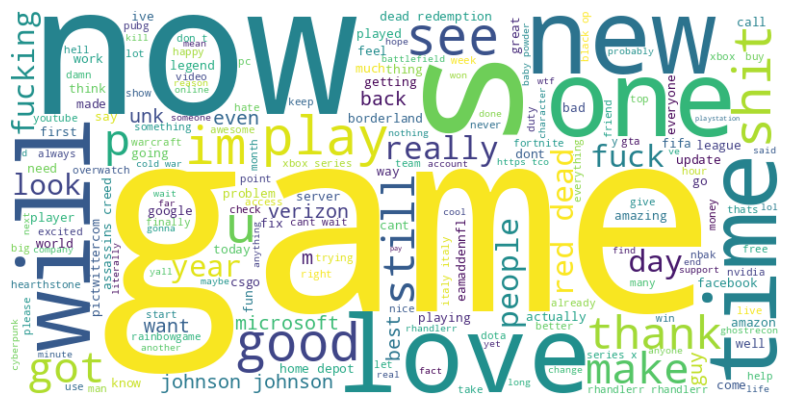

In [ ]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file
model.save('/content/sentiment_analysis_model.h5')
print("Model saved to /content/sentiment_analysis_model.h5")


Model saved to /content/sentiment_analysis_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
